# SYP project

Sentiment analysis.

## Phase 1: Baseline for Sentiment classification
Classify weather music reviews are positive or negative.

### Imports

In [8]:
import pandas as pd
import re

### Read in files

In [9]:
!pwd

/mnt/c/Users/sabrina/Dropbox/learning/bsc_data_science/4_2022_spring/2nd-year-project/2yp_sentiment_analysis/code


In [10]:
# https://www.delftstack.com/howto/linux/unzip-gz-file-linux/

# !gzip -d -k ../data/raw/music_reviews_dev.json.gz
# !gzip -d -k ../data/raw/music_reviews_train.json.gz
# !gzip -d -k ../data/raw/music_reviews_test_masked.json.gz 

In [11]:
# fixing trailing data error https://www.statology.org/valueerror-trailing-data/

data_train = pd.read_json('../data/raw/music_reviews_train.json', lines=True)
data_dev = pd.read_json('../data/raw/music_reviews_dev.json', lines=True)
data_test_masked = pd.read_json('../data/raw/music_reviews_test_masked.json', lines=True)

### EDA
#### Training data

In [12]:
data_train.isnull().sum()

verified              0
reviewTime            0
reviewerID            0
asin                  0
style             14113
reviewText           54
summary              31
unixReviewTime        0
sentiment             0
id                    0
vote              83795
image             99644
dtype: int64

In [13]:
data_train['sentiment'].value_counts()

positive    60783
negative    39217
Name: sentiment, dtype: int64

# BERT
from here: https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [21]:
df=data_train
df['concatSummaryReview'] = df['summary'] + ' ' + df['reviewText']
df['concatSummaryReview'] = df['concatSummaryReview'].str.lower().fillna('<NA>')

In [35]:
# one review to test tokeniser
text = df['concatSummaryReview'][0]

In [34]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [42]:
tokens = bert_tokenizer.tokenize(text)
print(tokens)

['gotta', 'listen', 'to', 'this', '!', 'so', 'creative', '!', 'love', 'his', 'music', '-', 'the', 'words', ',', 'the', 'message', '!', 'some', 'of', 'my', 'favorite', 'songs', 'on', 'this', 'cd', '.', 'i', 'should', 'have', 'bought', 'it', 'years', 'ago', '!']


In [43]:
token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

[10657, 4952, 2000, 2023, 999, 2061, 5541, 999, 2293, 2010, 2189, 1011, 1996, 2616, 1010, 1996, 4471, 999, 2070, 1997, 2026, 5440, 2774, 2006, 2023, 3729, 1012, 1045, 2323, 2031, 4149, 2009, 2086, 3283, 999]


In [44]:
bert_tokenizer.sep_token, bert_tokenizer.sep_token_id

('[SEP]', 102)

In [45]:
bert_tokenizer.cls_token, bert_tokenizer.cls_token_id

('[CLS]', 101)

In [46]:
bert_tokenizer.pad_token, bert_tokenizer.pad_token_id

('[PAD]', 0)

In [47]:
bert_tokenizer.unk_token, bert_tokenizer.unk_token_id
# unk = unknown

('[UNK]', 100)

In [48]:
encoding = bert_tokenizer.encode_plus(
    text, 
    add_special_tokens=True, 
    truncation=True, 
    padding="max_length", 
    return_attention_mask=True, 
    return_tensors="pt"
)

In [49]:
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [52]:
len(encoding['input_ids'][0])

512

In [69]:
df.concatSummaryReview.to_numpy()

array(['gotta listen to this! so creative!  love his music - the words, the message! some of my favorite songs on this cd. i should have bought it years ago!',
       'shame shame this tape can hardly be understood and it was listed for sale as "very good".  it\'s very bad.',
       "buy the cd.  do not buy the mp3. buy the cd.  do not buy the mp3 album.  download is no longer available.  but you don't find that out until after you have purchased it.",
       ..., "five stars i'm enjoying her album very much!",
       'bad digital recording - very sad these digital files are corrupted.  there are glitches in the recording -- very noticeable glitches.  extremely disappointed as i\'ve enjoyed other volumes of knardahl\'s recordings.  specifically, the opening of "lyric pieces, book 10, op. 71: iv. skogstillhet (peace of woods)".',
       "... the tempest live performed by the minnesota orchestra and liked it so much i wanted a recording i saw the tempest live performed by the minnesota o

In [60]:
token_lens = []

for txt in df.concatSummaryReview:
  tokens = bert_tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

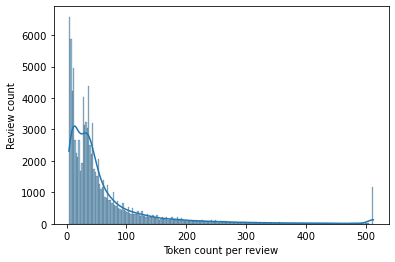

In [68]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.histplot(token_lens, kde=True)
plt.ylabel('Review count')
plt.xlabel('Token count per review');

# TfidfVectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = data_train['reviewText'].fillna('<NA>')

In [17]:
corpus

0        So creative!  Love his music - the words, the ...
1        This tape can hardly be understood and it was ...
2        Buy the CD.  Do not buy the MP3 album.  Downlo...
3        I love Dallas Holms music and voice!  Thank Yo...
4               Great memories of my early years in Christ
                               ...                        
99995                             Great old song. Love it.
99996    Daniel Smith has no more command of the bassoo...
99997                    I'm enjoying her album very much!
99998    These digital files are corrupted.  There are ...
99999    I saw the Tempest live performed by the Minnes...
Name: reviewText, Length: 100000, dtype: object

In [9]:
vectorizer = TfidfVectorizer()
corpus_vec = vectorizer.fit_transform(corpus)

In [10]:
vectorizer.get_feature_names_out()


# print(corpus_vec.shape)

array(['00', '000', '0000', ..., 'zzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'],
      dtype=object)

# CUDA set up

In [2]:
!nvidia-smi

Tue Mar 22 16:40:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.52       Driver Version: 511.79       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8    11W /  N/A |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import torch

print('CUDA available?', torch.cuda.is_available())
print('CUDA version:', torch.version.cuda)
print('GPU:', torch.cuda.get_device_name(0))

CUDA available? True
CUDA version: 10.2
GPU: NVIDIA GeForce RTX 2060
